# Generating 100,000 Transmission Spectra




In [2]:
import multiprocessing
import numpy as np
from tqdm import tqdm
import time
from spectres import spectres

In [3]:

from POSEIDON.core import create_planet
from POSEIDON.constants import R_J, M_J
from POSEIDON.core import make_atmosphere
from POSEIDON.core import compute_spectrum

In [4]:
from POSEIDON.core import create_star, wl_grid_constant_R
from POSEIDON.constants import R_Sun

#***** Wavelength grid *****#
 
wl_min = 0.5      # Minimum wavelength (um)
wl_max = 7.5      # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Example_model'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O','CO2','CO','CH4','NH3']   # The trace gases are H2O, CO2, CO, CH4, NH3

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'Iceberg')


from POSEIDON.core import read_opacities

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 500     # 500 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000    # 2500 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CO2 done
CO done
CH4 done
NH3 done
Opacity pre-interpolation complete.


In [5]:
# print the key values of the opac
print(opac.keys())
opac['sigma_stored'].shape, opac['CIA_stored'].shape, opac['T_fine'].shape, opac['log_P_fine'].shape, opac['Rayleigh_stored'].shape

dict_keys(['opacity_database', 'opacity_treatment', 'sigma_stored', 'CIA_stored', 'Rayleigh_stored', 'eta_stored', 'ff_stored', 'bf_stored', 'T_fine', 'log_P_fine'])


((5, 41, 351, 27081), (6, 351, 27081), (351,), (41,), (7, 27081))

In [6]:
# %%%%%%%%%%%%%%%%%%%%%%%%% Random model paramters %%%%%%%%%%%%%%%%%%%%%%%%%%% #

## Generating N random values
N = 100000 # number of models to generate 

R_s_rand = np.random.uniform(0.5, 3.0, N)
R_p_rand = np.random.uniform(0.1, 2, N)
g_p_rand = np.random.uniform(5, 40, N)

PT_params_rand = np.random.uniform(500, 3500, N)
log_kappa_cloud_rand = np.random.uniform(-7, 0.6, N)
log_P_cloud_rand = np.random.uniform(-4, 1, N)

all_rand_params = np.concatenate(( R_s_rand.reshape(N, 1), R_p_rand.reshape(N, 1), g_p_rand.reshape(N, 1), PT_params_rand.reshape(N, 1), log_kappa_cloud_rand.reshape(N,1), log_P_cloud_rand.reshape(N,1)), axis=1)

## log mixing ratios in the range -12 to -1
rand_mix_ratio = np.zeros((N, len(param_species)))
for i in range(len(param_species)):
    rand_mix_ratio[:, i] = np.random.uniform(-9, -2, N)
log_X_params_rand = rand_mix_ratio

# %%%%%%%%%%%%%%%%%%%%%%%%%%% Generating models %%%%%%%%%%%%%%%%%%%%%%%%%%%%% #

#***** Wavelength grid *****#
wl = wl_grid_constant_R(0.5, 7.5, 10000)
#***** Define stellar properties *****#
T_s, Met_s, log_g_s = 6000, -0.1, 4.50

#***** Define model *****#
planet_name = ''
model_name = 'Example_model'  # Model name used for plots, output files etc.
bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O','CO2','CO','CH4','NH3']   # The trace gases are H2O, CO2, CO, CH4, NH3

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile = 'isotherm', cloud_model = 'Iceberg')

# Specify the pressure grid of the atmosphere
P_min = 1.0e-6    # 1 ubar
P_max = 10       # 10 bar
N_layers = 100    # 100 layers
# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Wavelength grid for R=1000 (lower resolution for binning)
wl_r1000 = wl_grid_constant_R(0.5, 7.5, 1000)
wl_r1000 = wl_r1000[1:-1]

def get_params(i):
    params = all_rand_params[i]
    return params

def my_function(i):
    R_s, R_p, g_p, PT_params, log_kappa_cloud, log_P_cloud = get_params(i)
    R_s = R_s*R_Sun
    R_p = R_p*R_J
    star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')
    planet = create_planet(planet_name, R_p, gravity = g_p)
    P_ref = 1.0
    R_p_ref = R_p
    PT_params = np.array([PT_params])
    cloud_params = [log_kappa_cloud, log_P_cloud]
    atmosphere_full = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, samples[i],cloud_params)
    spectrum_full = compute_spectrum(planet, star, model, atmosphere_full, opac, wl, spectrum_type='transmission')
    binned_spectra_r1000 = spectres(wl_r1000, wl, spectrum_full, verbose=False)
    return binned_spectra_r1000

start = time.time()

if __name__ == '__main__':
    samples = log_X_params_rand
    num_processors = 8
    with multiprocessing.Pool(num_processors) as pool:
        results = []
        for result in tqdm(pool.map(my_function, range(len(samples))), total=len(samples)):
            results.append(result)

trans_spectras = np.array(results)

end = time.time()

print("Time taken to generate the models: ", end - start)
print(trans_spectras.shape)
print(wl_r1000.shape)

# # saving the genrated models and the params as npy files
path_gsoc_data = '/home/exolab/GSoC/POS_Data/100k/'
np.save(path_gsoc_data+'100k_pos_trans_spectras_R1000',trans_spectras)
np.save(path_gsoc_data+'100k_pos_logX_R1000',log_X_params_rand)
np.save(path_gsoc_data+'100k_pos_wl_r1000',wl_r1000)
np.save(path_gsoc_data+'100k_pos_params_R1000',all_rand_params)

print('All the generated models are saved at : ',path_gsoc_data)

100%|██████████| 100000/100000 [00:00<00:00, 2720041.50it/s]


Time taken to generate the models:  19086.67685508728
(100000, 2706)
(2706,)
All the generated models are saved at :  /home/exolab/GSoC/POS_Data/100k/


#### Printing some models

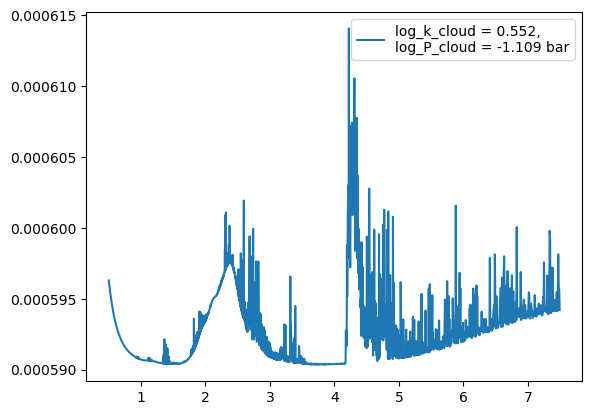

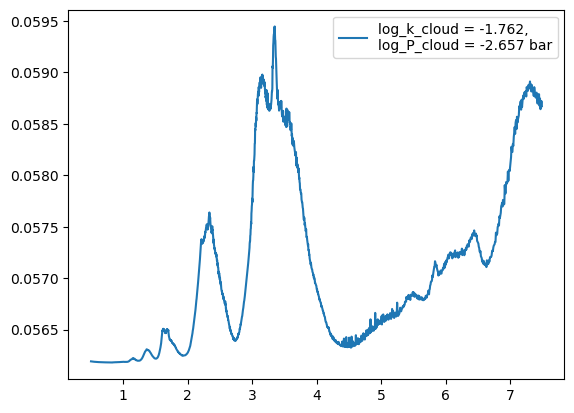

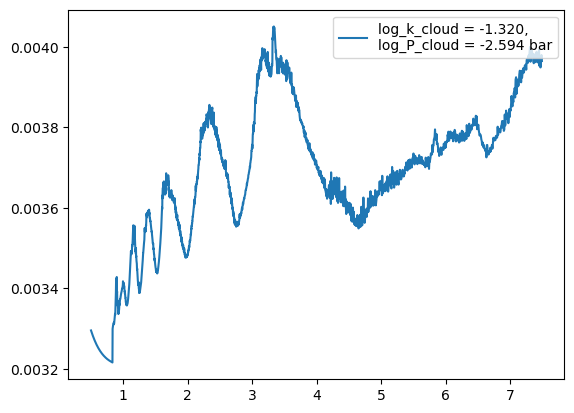

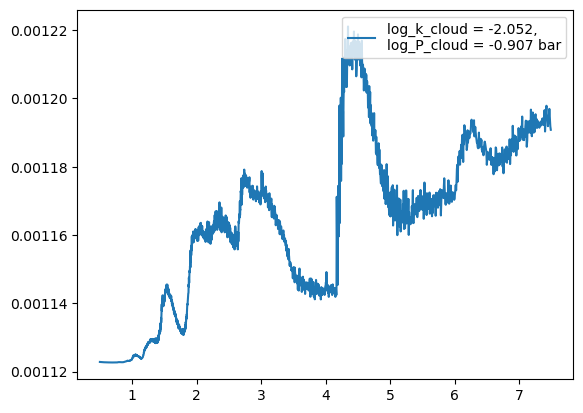

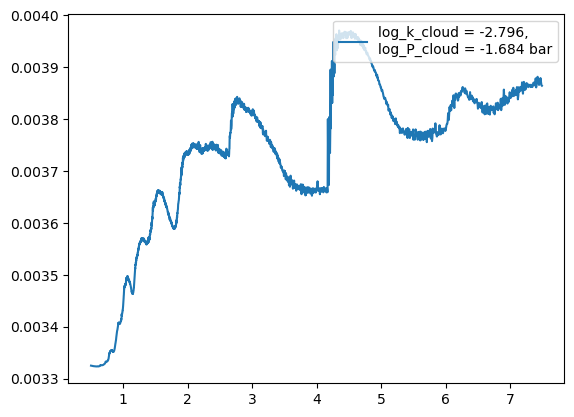

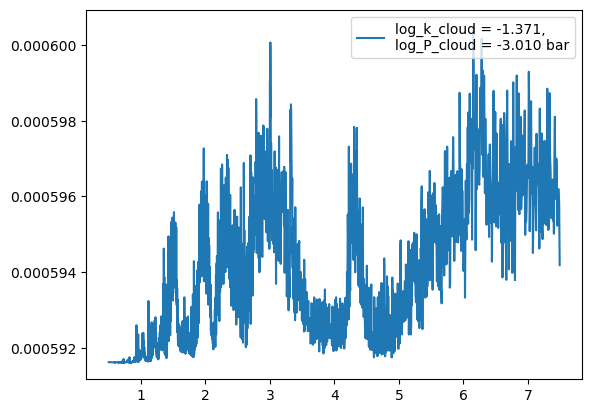

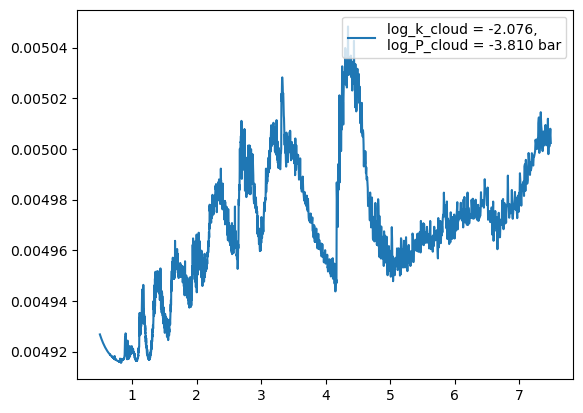

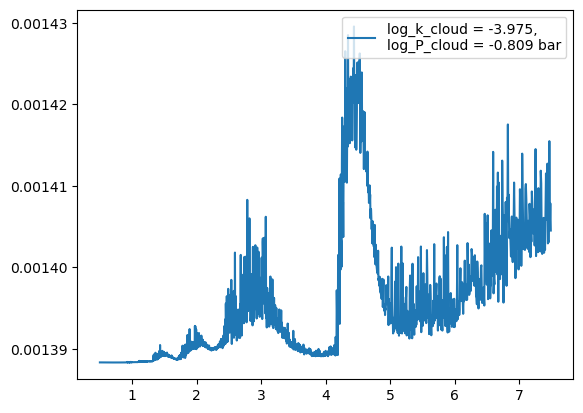

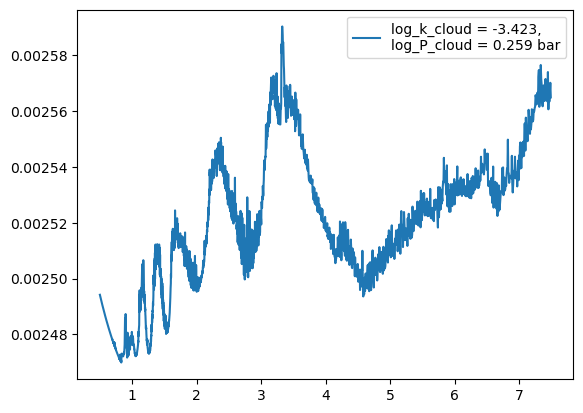

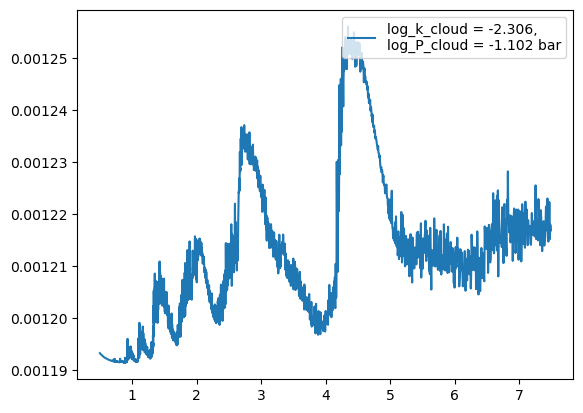

In [41]:
from matplotlib import pyplot as plt
indx = np.random.randint(0,10)
for i in range(10):
    plt.plot(wl_r1000,trans_spectras[i],label=f'log_k_cloud = {all_rand_params[i][4]:.3f}, \nlog_P_cloud = {all_rand_params[i][5]:.3f} bar')
    plt.legend(loc = 'upper right')
    plt.show()

#### Binnig to R=100

In [7]:
## Bining the data to R=100
wl_r100 = wl_grid_constant_R(wl_min, wl_max, 100)
wl_r100 = wl_r100[1:-1]

binned_flux_r100 = np.zeros((all_rand_params.shape[0], len(wl_r100)))
for i in tqdm(range(all_rand_params.shape[0])):
    binned_flux_r100[i] = spectres(wl_r100, wl_r1000, trans_spectras[i], verbose=False)

binned_flux_r100.shape

100%|██████████| 100000/100000 [05:58<00:00, 279.31it/s]


(100000, 269)

In [75]:
np.save('/home/exolab/GSoC/POS_Data/100k/wl_r100',wl_r100)
np.save('/home/exolab/GSoC/POS_Data/100k/binned_flux_r100',binned_flux_r100)

In [8]:
import pandas as pd
df1 = pd.DataFrame(all_rand_params, columns = ['R_s', 'R_p', 'g_p', 'Temp', 'log_kappa_cloud', 'log_P_cloud'])
df2 = pd.DataFrame(log_X_params_rand, columns = param_species)
df3 = pd.concat([df1, df2], axis=1)
df4 = pd.DataFrame(binned_flux_r100)
df5 = pd.concat([df4, df3], axis=1)
df5

,0,1,2,3,4,5,6,7,8,9,...,R_p,g_p,Temp,log_kappa_cloud,log_P_cloud,H2O,CO2,CO,CH4,NH3
0,0.004014,0.004014,0.004014,0.004014,0.004014,0.004014,0.004014,0.004014,0.004014,0.004014,...,1.658348,17.176982,3327.875478,-3.855474,-3.844470,-8.889865,-4.018888,-3.195541,-7.868857,-5.895533
1,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,0.000107,...,0.258443,16.036432,2034.071133,-3.014919,-2.962217,-3.225697,-2.038615,-5.329029,-3.169883,-3.206833
2,0.000358,0.000358,0.000358,0.000358,0.000357,0.000357,0.000357,0.000357,0.000357,0.000357,...,0.503774,9.066010,1712.661454,-2.246068,-1.677456,-3.993484,-2.895214,-7.397882,-8.908273,-7.172669
3,0.012516,0.012516,0.012516,0.012516,0.012516,0.012516,0.012515,0.012515,0.012515,0.012515,...,0.562965,7.254639,3287.260930,-1.086659,-3.761693,-8.448541,-3.301345,-4.516020,-7.289866,-7.753208
4,-0.001460,-0.001460,-0.001461,-0.001461,-0.001461,-0.001462,-0.001462,-0.001462,-0.001462,-0.001462,...,0.144485,8.543504,1674.394288,-1.410270,-3.851043,-3.656284,-3.879207,-7.050328,-8.809873,-2.528554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.051244,0.051231,0.051218,0.051204,0.051189,0.051176,0.051165,0.051157,0.051161,0.051157,...,1.127280,23.840443,1888.494072,-0.852804,0.174308,-8.328901,-4.306115,-5.311498,-4.732160,-2.606973
99996,0.013549,0.013549,0.013549,0.013549,0.013549,0.013549,0.013549,0.013549,0.013549,0.013549,...,0.821014,39.964869,608.918946,-0.080777,-2.934876,-2.272423,-5.898074,-4.111940,-6.111954,-5.232814
99997,0.028945,0.028936,0.028931,0.028919,0.028914,0.028910,0.028905,0.028909,0.028904,0.028898,...,1.585554,21.984786,1662.144409,-5.621292,-0.207594,-2.164336,-5.986446,-4.369003,-3.304317,-8.281498
99998,0.004606,0.004605,0.004604,0.004602,0.004601,0.004600,0.004599,0.004598,0.004596,0.004595,...,1.523560,21.601466,2205.683764,-2.764175,0.358894,-3.131075,-5.491361,-3.416492,-4.298408,-5.343337
